In [82]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [107]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [165]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [174]:
# get predominant transcripts for poder
df = get_melted_pi_counts_table('poder')

In [175]:
# remove anything w/ 0 pi val
# can adjust this threshold later if needed
df = df.loc[df.pi>0]

# keep transcripts that have at least 11 samples with more than 0.1 cpm
t_cpm_thresh = 0.1
n_t_sample_thresh = 11
temp = df[['sample', 'tid', 't_tpm']]
temp = temp.loc[temp['t_tpm']>=t_cpm_thresh]
temp = temp.drop('t_tpm', axis=1)
temp = temp.groupby('tid').nunique().reset_index().rename({'sample':'n_t_samples'}, axis=1)
df = df.merge(temp, how='left', on='tid')

# keep genes with at least 11 samples with at least 10 counts
g_counts_thresh = 10
n_g_sample_thresh = 11
temp = df[['sample', 'gid', 'g_counts']]
temp = temp.loc[temp.g_counts>=g_counts_thresh]
temp = temp.drop('g_counts', axis=1)
temp = temp.groupby('gid').nunique().reset_index().rename({'sample':'n_g_samples'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# keep genes with more than 1 transcript
temp = df[['tid', 'gid']].groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# perform the filtering
df = df.loc[df.n_t_samples>=n_t_sample_thresh]
df = df.loc[df.n_g_samples>=n_g_sample_thresh]
df = df.loc[df.n_t>1]

In [178]:
df.head()

,tid,gid,sample,pi,t_tpm,population,g_counts,n_t_samples,n_g_samples,n_t
0,ENST00000010132.6,ENSG00000010219.14,CEU3,0.309327,10.340900,CEU,333.594840,43.0,43.0,17
3,ENST00000214893.10,ENSG00000099219.15,CEU3,0.857143,1.546140,CEU,18.000025,38.0,16.0,7
4,ENST00000217961.5,ENSG00000101846.9,CEU3,0.125000,0.125266,CEU,10.000000,20.0,26.0,4
6,ENST00000220966.10,ENSG00000104524.14,CEU3,0.500000,1.202550,CEU,24.000000,30.0,31.0,4
8,ENST00000222572.8,ENSG00000105854.13,CEU3,0.291667,0.233830,CEU,7.999990,15.0,11.0,5


In [176]:
# # verify gene transform
# len(df.loc[(df.gid=='ENSG00000000419.14')&(df.g_counts>=g_cpm_thresh)]['sample'].unique())
# gid = 'ENSG00000002016.18'
# len(df.loc[(df.gid==gid)&(df.g_counts>=g_cpm_thresh)]['sample'].unique())
# gid = 'ENSG00000038427.16'
# len(df.loc[(df.gid==gid)&(df.g_counts>=g_cpm_thresh)]['sample'].unique())

In [177]:
# # verify t transform
# len(df.loc[(df.tid=='ENST00000010132.6')&(df.tpm>=t_cpm_thresh)])
# len(df.loc[(df.tid=='ENST00000155093.8')&(df.tpm>=t_cpm_thresh)])

In [ ]:
# groupby sample and gene to compute entropy 
# over pi values
e_df = df[['gid', 'sample',
           'pi', 'population']].groupby(['gid', 'sample',
                                         'population']).apply(lambda x: st.entropy(x.pi))
e_df = e_df.reset_index().rename({0:'entropy'}, axis=1)

In [85]:
e_df.head(1)

,gid,sample,population,entropy
0,ENSG00000000419.14,AJI1,AJI,0.619132


In [86]:
# validate that this worked
temp_list = df.loc[(df['sample']=='AJI1')&(df.gid=='ENSG00000000419.14')].pi.tolist()
st.entropy(temp_list)

0.6191324068842047

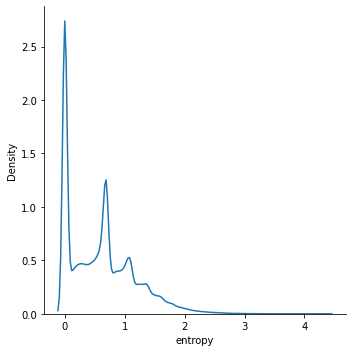

In [23]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='entropy')

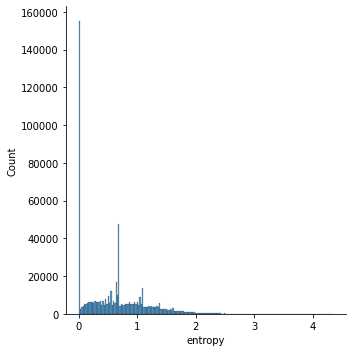

In [24]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='entropy')
# peaks are probably at the different theoretical maxes maybe?

In [87]:
# get # isoforms expressed vs. entropy
n_t_df = df[['tid', 'gid', 'sample']].groupby(['gid', 'sample']).nunique().reset_index().rename({'tid': 'n_t'}, axis=1)
e_df = e_df.merge(n_t_df, on=['gid', 'sample'])

In [101]:
# remove genes w/ just one isofomr
print(len(e_df.index))
e_df = e_df.loc[e_df.n_t!=1]
print(len(e_df.index))

602839
449774


In [102]:
df.loc[(df.gid=='ENSG00000238260.4')&(df['sample']=='AJI2')]

,tid,gid,sample,pi,tpm,population
4258829,transcript_204923,ENSG00000238260.4,AJI2,0.5,0.039442,AJI
4258833,transcript_204927,ENSG00000238260.4,AJI2,0.5,0.039442,AJI


In [103]:
e_df.loc[(e_df.gid=='ENSG00000238260.4')&(e_df['sample']=='AJI2')]

,gid,sample,population,entropy,n_t,norm_entropy
475263,ENSG00000238260.4,AJI2,AJI,0.693147,2,1.0


In [104]:
# e_df.rename({'n_t_x':'n_t'}, axis=1, inplace=True)
# e_df.drop('n_t_y', axis=1, inplace=True)

In [92]:
# normalize entropy values to max entropy values computed using 
# this stragtegy
# https://mc-stan.org/posterior/reference/entropy.html
e_df['norm_entropy'] = e_df.entropy/np.log(e_df.n_t)

In [93]:
# check to make sure it worked
print(0.619132/np.log(13))
print(e_df.head())

0.24138176381491552
                  gid sample population   entropy  n_t  norm_entropy
0  ENSG00000000419.14   AJI1        AJI  0.619132   13      0.241382
1  ENSG00000000419.14   AJI2        AJI  0.845254   14      0.320286
2  ENSG00000000419.14   AJI3        AJI  0.725509   17      0.256073
3  ENSG00000000419.14   AJI4        AJI  0.670090   12      0.269664
4  ENSG00000000419.14   AJI5        AJI  0.794382   17      0.280382


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


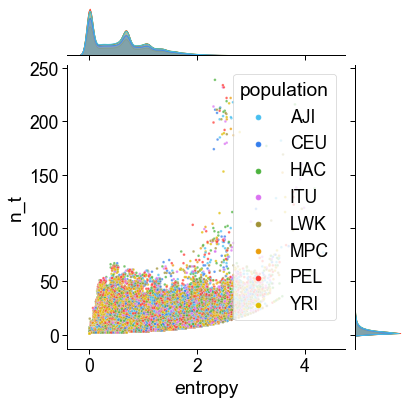

In [69]:
# plot
c_dict, order = get_population_colors()
sns.jointplot(e_df, x='entropy', y='n_t', hue='population', palette=c_dict,
              alpha=0.75, s=7)

Text(2, 95, 'y = 1.48 + 5.009x')

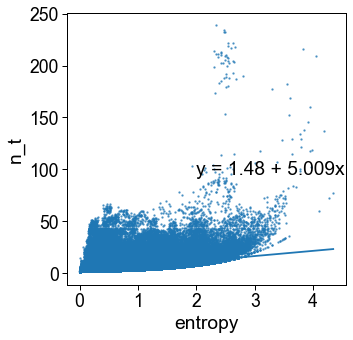

In [70]:
# plot
init_plot_settings(aspect='square')
p = sns.regplot(e_df, x='entropy', y='n_t', scatter_kws={'s': 2,
                                                         'alpha': 0.6})

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = st.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
plt.text(2, 95, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')

In [45]:
# what are these outliers?
print(len(e_df.loc[e_df.n_t>150]))
print(len(e_df.loc[e_df.n_t>150].gid.unique()))
print(e_df.loc[e_df.n_t>150].gid.unique())
print(e_df.loc[e_df.n_t>150][['sample', 'gid']].groupby('gid').count())

49
2
['ENSG00000226777.10' 'ENSG00000234741.11']
                    sample
gid                       
ENSG00000226777.10       7
ENSG00000234741.11      42


In [57]:
# lets try to look at some more reasonable exmples,
# maybe genes w/ <10 transcripts and high entropy
# lets say >2
temp = e_df.loc[e_df.n_t<10]
temp = temp.loc[temp.entropy>2]
temp.sort_values(by='entropy', ascending=False).head()
print(len(temp.index))
print(len(temp.gid.unique()))

# nearly half of genes in this category are repeated across samples
temp.head()

775
440


,gid,sample,population,entropy,n_t
522,ENSG00000001631.17,CEU1,CEU,2.058253,9
524,ENSG00000001631.17,CEU3,CEU,2.029161,9
550,ENSG00000001631.17,PEL4,PEL,2.083215,9
619,ENSG00000002330.14,LWK1,LWK,2.064235,8
4499,ENSG00000007038.11,MPC1,MPC,2.079442,8


In [71]:
e_df.head()

,gid,sample,population,entropy,n_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,0.619132,13,0.241382
1,ENSG00000000419.14,AJI2,AJI,0.845254,14,0.320286
2,ENSG00000000419.14,AJI3,AJI,0.725509,17,0.256073
3,ENSG00000000419.14,AJI4,AJI,0.670090,12,0.269664
4,ENSG00000000419.14,AJI5,AJI,0.794382,17,0.280382


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


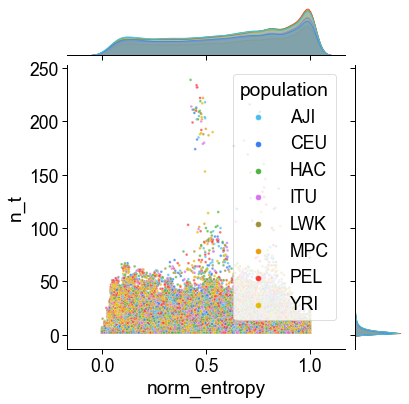

In [94]:
# normalized
# plot
c_dict, order = get_population_colors()
sns.jointplot(e_df, x='norm_entropy', y='n_t', hue='population', palette=c_dict,
              alpha=0.75, s=7)

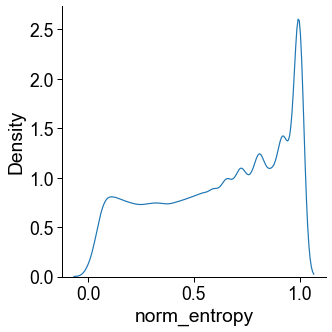

In [95]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='norm_entropy')

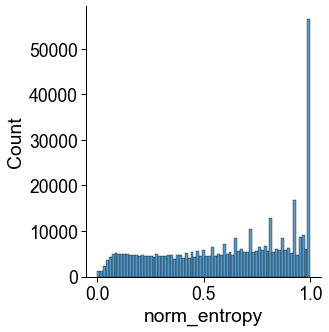

In [96]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='norm_entropy')
# peaks are probably at the different theoretical maxes maybe?

In [97]:
e_df.head()

,gid,sample,population,entropy,n_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,0.619132,13,0.241382
1,ENSG00000000419.14,AJI2,AJI,0.845254,14,0.320286
2,ENSG00000000419.14,AJI3,AJI,0.725509,17,0.256073
3,ENSG00000000419.14,AJI4,AJI,0.670090,12,0.269664
4,ENSG00000000419.14,AJI5,AJI,0.794382,17,0.280382


In [98]:
e_df.sort_values(by='norm_entropy', ascending=False)

,gid,sample,population,entropy,n_t,norm_entropy
554861,ENSG00000291176.2,AJI2,AJI,4.343805,77,1.0
475264,ENSG00000238260.4,AJI3,AJI,1.609438,5,1.0
550434,ENSG00000290922.2,HAC4,HAC,1.609438,5,1.0
513959,ENSG00000266970.4,LWK4,LWK,1.609438,5,1.0
508369,ENSG00000261390.9,CEU1,CEU,1.609438,5,1.0
...,...,...,...,...,...,...
602788,novelGene_ENSG00000309324.1_AS,PEL4,PEL,0.000000,1,NaN
602791,novelGene_ENSG00000309324.1_AS,YRI2,YRI,0.000000,1,NaN
602792,novelGene_ENSG00000309324.1_AS,YRI3,YRI,0.000000,1,NaN
602794,novelGene_ENSG00000309324.1_AS,YRI6,YRI,0.000000,1,NaN


In [99]:
df.loc[(df.gid=='ENSG00000238260.4')&(df['sample']=='AJI3')]

,tid,gid,sample,pi,tpm,population
3388187,transcript_204923,ENSG00000238260.4,AJI3,0.2,0.030543,AJI
3388188,transcript_204924,ENSG00000238260.4,AJI3,0.2,0.030543,AJI
3388189,transcript_204925,ENSG00000238260.4,AJI3,0.2,0.030543,AJI
3388190,transcript_204926,ENSG00000238260.4,AJI3,0.2,0.030543,AJI
3388191,transcript_204927,ENSG00000238260.4,AJI3,0.2,0.030543,AJI
